In [1]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import time
from datetime import datetime
import scipy.optimize as opt
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
#plt.style.use("ggplot")
mpl.pyplot.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams["font.size"] = 13
#mpl.rcParams["font.family"] = 'Osaka'

import sys
sys.path.append('../code/')

#from hash import *
#from plot_path import *
from simulation_additional import *

## simulation for additional results

### As for $w^*$

* `opt_w` is a function that computes the optimal winning rate given a price.
    - The function is implicitly defined; compute it in advance and save it as an array. (`opt_w.csv`)
    - For range $[100, 11000]$, we have $w^*$ for every \$50.

### As for miners' profits

* Suppose that you have one unit (1 EHash/s) of mining facility with marginal cost $c$.

* How much net profit can you earn for 84 days (12 weeks).

* Given a price path and cost $c$, the 84-day expected net profit is $\sum_t \max\{0, (R(t) - c)\}$ under various DAAs．
    - compute the average over all 5000 paths.
    - for each $c$ in [0.5, 1, 1.5, ..., 4.0, 4.5].

* Below, DAA-0 corresponds to the first-best DAA: it chooses $W^*(t)$ every period.

Rewrite the code in order to store the following data:
1. realized winning rate $w$
1. optimal winning rate $w^*$
1. expected reward(/EHash) $R$ 
1. Hash rate $H$
1. Block time $B$

### Conduct simulations

* All the functions used below are written in `simulation_additional.py`.

In [3]:
dir_sim = '/Volumes/Data/research/BDA/simulation/'
df_opt_w = pd.read_csv(dir_sim + 'opt_w.csv', index_col=0)

In [11]:
df_opt_w.head()

,opt_w
100,0.000480
150,0.000370
200,0.000306
250,0.000263
300,0.000232


In [21]:
df_price = pd.read_csv(dir_sim+'sim_prices_ps=0.csv')

In [5]:
# data for pre-simulation period
path = '../data/BTCdata_presim.csv'
df = pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={'blocktime': 'block_times', 'price': 'prices', 'probability of success /Eh': 'winning_rates'})
df.head()

# test
dir_sim = '/Volumes/Data/research/BDA/simulation/'
df_opt_w = pd.read_csv(dir_sim + 'opt_w.csv', index_col=0)
df_price = pd.read_csv(dir_sim+'sim_prices_ps=0.csv')
df_exprvs = pd.read_csv(dir_sim+'sim_exprvs.csv')
df_BTC = pd.DataFrame()

In [6]:
sim = simulation(prev_data=df)
prices = df_price.loc[:, 'iter_0']
exprvs = df_exprvs.loc[:, 'iter_0']
sim.sim_DAA_1(prices=prices, exprvs=exprvs, df_opt_w=df_opt_w)

In [7]:
sim.block_times

array([ 1.183,  8.023, 25.506, ..., 11.547,  6.028,  8.499])

In [8]:
sim.hash_rates

array([30.333, 30.299, 30.173, ..., 45.086, 45.069, 45.106])

In [9]:
sim.expected_rewards

array([1.569, 1.568, 1.565, ..., 2.005, 2.004, 2.006])

In [10]:
sim.winning_rates

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
sim.optimal_winning_rates

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
sim = simulation(prev_data=df)
sim.sim_DAA_2(prices=prices, exprvs=exprvs, df_opt_w=df_opt_w)

In [13]:
sim.expected_rewards

array([1.632, 1.612, 1.613, ..., 2.455, 2.457, 2.436])

In [4]:
sim = simulation(prev_data=df)
sim.sim_DAA_0(prices=prices, exprvs=exprvs, df_opt_w=df_opt_w)

### simulation with small dataset

In [2]:
# data for pre-simulation period
path = '../data/BTCdata_presim.csv'
prev_data = pd.read_csv(path)
prev_data['time'] = pd.to_datetime(prev_data['time'])
prev_data = prev_data.rename(columns={'blocktime': 'block_times', 'price': 'prices', 'probability of success /Eh': 'winning_rates'})

# test
dir_sim = '/Volumes/Data/research/BDA/simulation/'
df_opt_w = pd.read_csv(dir_sim + 'opt_w.csv', index_col=0)
#df_price = pd.read_csv(dir_sim+'sim_prices_ps=0.csv')
#df_exprvs = pd.read_csv(dir_sim+'sim_exprvs.csv')

prev_data.head()

,height,time,block_times,prices,winning_rates,expected return (USD/Eh)
0,549427,2018-11-09 19:26:14,5.783333,6343.32,0.000032,2.587754
1,549428,2018-11-09 19:26:20,0.100000,6343.32,0.000032,2.574300
2,549429,2018-11-09 19:37:51,11.516667,6341.26,0.000032,2.593078
3,549430,2018-11-09 19:45:57,8.100000,6341.26,0.000032,2.595087
4,549431,2018-11-09 19:54:51,8.900000,6341.26,0.000032,2.591786


In [3]:
np.random.seed(2019831)
generate_simulation_data(num_iter=5, prev_data=prev_data)

### Simulation with large dataset

In [4]:
np.random.seed(2019831)
generate_simulation_data(num_iter=5000, prev_data=prev_data)

### The errors under various DAAs

#### The errors under DAA-1, DAA-2

Compute the sum of squeared error for each path $p_n$ $(n = 0, \dots, 4999)$
\[
e_n := \sum_t [w(t) - w^*(t)]^2
\]
and compute
\[
\frac{1}{5000} \sum_{n} e_n
\]
(MSE for a path)

In [71]:
def MSE(df1=pd.DataFrame(), df2=pd.DataFrame()):
    '''
    The name of columns should be iter_0, iter_2, ..., iter_4999.
    '''
    array1 = df1.values
    array2 = df2.values
    
    array1[np.isnan(array1)] = 0
    array2[np.isnan(array2)] = 0
    
    temp = array1 - array2
    temp = temp**2
    
    temp = np.mean(temp, axis=0)
    temp = np.mean(temp)
    return temp

In [75]:
#dir_sim = '/Volumes/Data/research/BDA/simulation/'
dir_sim = '/Users/kyo/prog/BDA/simulated_data/'
df_daa1_winrate = pd.read_csv(dir_sim + 'DAA-1_winrate_ps0_5000obs.csv', index_col=0)
df_daa1_optwinrate = pd.read_csv(dir_sim + 'DAA-1_optwinrate_ps0_5000obs.csv', index_col=0)

In [78]:
error_DAA1 = MSE(df1=df_daa1_winrate, df2=df_daa1_optwinrate)
error_DAA1

1.35755571152717e-10

In [79]:
# free up memory
del df_daa1_optwinrate, df_daa1_winrate
gc.collect()

5433

In [80]:
#dir_sim = '/Volumes/Data/research/BDA/simulation/'
dir_sim = '/Users/kyo/prog/BDA/simulated_data/'
df_daa2_winrate = pd.read_csv(dir_sim + 'DAA-2_winrate_ps0_5000obs.csv', index_col=0)
df_daa2_optwinrate = pd.read_csv(dir_sim + 'DAA-2_optwinrate_ps0_5000obs.csv', index_col=0)

error_DAA2 = MSE(df1=df_daa2_winrate, df2=df_daa2_optwinrate)
error_DAA2

5.6909088461042424e-12

* MSE under DAA-1 is $1.358 \times 10^{-10}$.

* MSE under DAA-2 is $5.691 \times 10^{-12}$.

In [82]:
error_DAA1/error_DAA2

23.8548138485208

### Miners' payoff

In [11]:
def MeanExpectedReward(df_expreward, miner_cost):
    temp = df_expreward.values
    temp[np.isnan(temp)] = 0
    temp = temp - miner_cost
    temp[temp < 0] = 0
    column_sum = np.sum(temp, axis=0)
    return np.mean(column_sum)

In [100]:
MeanExpectedReward(df_expreward=df_test, miner_cost=1.5)

473.41838940814387

In [102]:
MeanExpectedReward(df_expreward=df_test, miner_cost=2.0)

1.0215292614066407

In [103]:
del df_daa0_expreward
gc.collect()

4412

In [15]:
#dir_sim = '/Volumes/Data/research/BDA/simulation/'
dir_sim = '/Users/kyo/prog/BDA/simulated_data/'
# df_daa0_expreward = pd.read_csv(dir_sim + 'DAA-0_expreward_ps0_5000obs.csv', index_col=0)
# df_daa1_expreward = pd.read_csv(dir_sim + 'DAA-1_expreward_ps0_5000obs.csv', index_col=0)
# df_daa2_expreward = pd.read_csv(dir_sim + 'DAA-2_expreward_ps0_5000obs.csv', index_col=0)

#cost_list = [0.5, 1, 1.5, 2, 3.0, 3.5, 4.0, 4.5]
cost_list = np.arange(0.5, 5.05, 0.05)
daa_list = ['DAA-1', 'DAA-2', 'DAA-0']
df_list = [df_daa1_expreward, df_daa2_expreward, df_daa0_expreward]

table = pd.DataFrame()
for daa, df in zip(daa_list, df_list):
    for cost in cost_list:
        reward_3months = MeanExpectedReward(df_expreward=df, miner_cost=cost)
        table.loc[cost, daa] = reward_3months
table

,DAA-1,DAA-2,DAA-0
0.50,14956.682848,16519.253075,16696.948611
0.55,14461.986819,15916.581815,16084.928001
0.60,13967.313669,15313.910555,15472.907391
0.65,13472.686692,14711.239295,14860.886781
0.70,12978.147335,14108.568035,14248.866171
0.75,12483.770364,13505.896775,13636.845561
0.80,11989.660537,12903.225515,13024.824951
0.85,11495.992900,12300.554255,12412.804341
0.90,11002.996393,11697.882995,11800.783731
0.95,10510.958520,11095.211735,11188.763121


In [16]:
table.to_csv(dir_sim+'exprewards_miners.csv')

In [2]:
dir_sim = '/Users/kyo/prog/BDA/simulated_data/'
df_miner_rewards = pd.read_csv(dir_sim+'exprewards_miners.csv', index_col=0)
df_miner_rewards = df_miner_rewards.rename(columns={'DAA-0':'first-best', 'DAA-1':'DAA-1(2016)', 'DAA-2':'DAA-2(144)'})
df_miner_rewards.head()

,DAA-1(2016),DAA-2(144),first-best
0.50,14956.682848,16519.253075,16696.948611
0.55,14461.986819,15916.581815,16084.928001
0.60,13967.313669,15313.910555,15472.907391
0.65,13472.686692,14711.239295,14860.886781
0.70,12978.147335,14108.568035,14248.866171


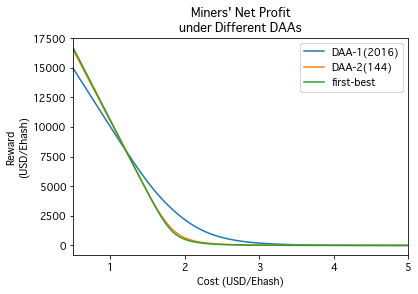

In [4]:
df_miner_rewards.plot()
plt.xlabel('Cost (USD/Ehash)')
plt.ylabel('Reward\n(USD/Ehash)')
plt.title('Miners\' Net Profit\nunder Different DAAs')
plt.show()

In [4]:
dir_sim_2 = '/Users/kyo/prog/BDA/data/'
df_asicspec = pd.read_csv(dir_sim_2+'asicefficiencySHA256.csv', index_col=0)
df_asicspec.head()

,Release,Power Efficiency (kWh/Eh),Electricity Cost (USD/Eh)
Model,,,
ASICminer 8 Nano Pro,2018/05,14.6199,0.8772
MicroBT Whatsminer M10S,2018/09,17.6768,1.0606
MicroBT Whatsminer M10,2018/09,18.0556,1.0833
Innosilicon T2 Turbo+ 32T,2018/09,19.0972,1.1458
Innosilicon T2 Turbo,2018/08,22.9167,1.3750


In [6]:
df_asicspec['Electricity Cost (USD/Eh)'].values

array([0.877, 1.061, 1.083, 1.146, 1.375, 1.417, 1.429, 1.438, 1.458,
       1.521, 1.542, 1.552, 1.571, 1.581, 1.6  , 1.617, 1.641, 1.753,
       1.833, 1.833, 2.733, 4.279])

In [5]:
asicspecs = df_asicspec['Electricity Cost (USD/Eh)'].values

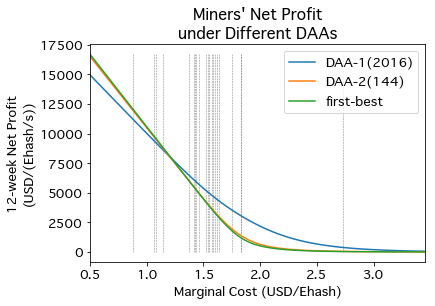

In [7]:
#plt.style.use('seaborn-bright')
#plt.style.use('ggplot')
plt.rcParams["font.size"] = 13
mpl.rcParams["font.family"] = 'Osaka'

df_miner_rewards[0.5:3.5].plot()
min_y = df_miner_rewards[0.5:3.5].min().min()
max_y = df_miner_rewards[0.5:3.5].max().max()
for cost in asicspecs:
    plt.vlines(cost, min_y, max_y, linestyle='--', linewidth=0.5, colors='gray')  # vertical line
plt.xlabel('Marginal Cost (USD/Ehash)')
plt.ylabel('12-week Net Profit\n(USD/(Ehash/s))')
plt.title('Miners\' Net Profit\nunder Different DAAs')
plt.show()